### Get Data

In [9]:
import numpy as n
import random
import pandas as pd
import gzip
n = 40428967  #total number of records in the clickstream data 
sample_size = 100000
skip_values = sorted(random.sample(range(1,n), n-sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with gzip.open('train.gz') as f:
    all_data = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, skiprows = skip_values)

<ipython-input-9-fa1325bdb216>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')


In [10]:
all_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10018930650935227325,0,2014-10-21,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,1,0,20596,320,50,2161,0,35,-1,157
1,10053027485503883989,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,100084,79
2,10148883107770136853,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20366,320,50,2333,0,39,-1,157
3,1018689453842445174,0,2014-10-21,1002,0,f528e1e7,0f095819,50e219e0,ecad2386,7801e8d9,...,0,0,20077,300,50,2292,0,559,100105,70
4,10209096537168357791,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15703,320,50,1722,0,35,-1,79


In [21]:
# saving to csv file
all_data.to_csv (r'C:\Users\kaviy\Desktop\Assignment4\Part2\final_snack_data.csv', index = False, header=True)

In [49]:
all_data = pd.read_csv("final_snack_data.csv")
all_data.head()

,user_id,Item_id,Rating,click,I1,I2,I3,I4,I5,I6,...,I12,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,50,4,3,0,1005,1,1,0,20596,320,...,157,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,224d24e9,d14c4241
1,39,1,2,0,1005,0,1,0,15705,320,...,79,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,afa320bb,8a4875bd
2,18,13,2,0,1005,0,1,0,20366,320,...,157,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,67287d76,24f6b932
3,40,10,2,0,1002,0,0,0,20077,300,...,70,f528e1e7,0f095819,50e219e0,ecad2386,7801e8d9,07d7df22,465ead49,b888c4b6,021b641d
4,46,15,2,0,1005,0,1,0,15703,320,...,79,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,c64f8ed3,a5bce124


In [50]:
nume_cols = ["I" + str(i) for i in range(1, 12)]
cate_cols = ["C" + str(i) for i in range(1, 10)]
label_col = "click"



In [54]:
import sys, os
sys.path.append("../../")
import numpy as np
import lightgbm as lgb
import papermill as pm
import pandas as pd
import category_encoders as ce
from tempfile import TemporaryDirectory
from sklearn.metrics import roc_auc_score, log_loss

import import_ipynb
import lightgbm_utils as lgb_utils
#import reco_utils.dataset.criteo as criteo

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
LightGBM version: 3.0.0


### Parameter Setting

In [55]:
MAX_LEAF = 64
MIN_DATA = 20
NUM_OF_TREES = 100
TREE_LEARNING_RATE = 0.15
EARLY_STOPPING_ROUNDS = 20
METRIC = "auc"
SIZE = "sample"

In [56]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'num_class': 1,
    'objective': "binary",
    'metric': METRIC,
    'num_leaves': MAX_LEAF,
    'min_data': MIN_DATA,
    'boost_from_average': True,
    #set it according to your cpu cores.
    'num_threads': 20,
    'feature_fraction': 0.8,
    'learning_rate': TREE_LEARNING_RATE,
}

### Data Preparation

In [57]:
# split data to 3 sets    
length = len(all_data)
train_data = all_data.loc[:0.8*length-1]
valid_data = all_data.loc[0.8*length:0.9*length-1]
test_data = all_data.loc[0.9*length:]

### Ordinal Encoding

In [58]:
ord_encoder = ce.ordinal.OrdinalEncoder(cols=cate_cols)

def encode_csv(df, encoder, label_col, typ='fit'):
    if typ == 'fit':
        df = encoder.fit_transform(df)
    else:
        df = encoder.transform(df)
    y = df[label_col].values
    del df[label_col]
    return df, y

train_x, train_y = encode_csv(train_data, ord_encoder, label_col)
valid_x, valid_y = encode_csv(valid_data, ord_encoder, label_col, 'transform')
test_x, test_y = encode_csv(test_data, ord_encoder, label_col, 'transform')

print('Train Data Shape: X: {trn_x_shape}; Y: {trn_y_shape}.\nValid Data Shape: X: {vld_x_shape}; Y: {vld_y_shape}.\nTest Data Shape: X: {tst_x_shape}; Y: {tst_y_shape}.\n'
      .format(trn_x_shape=train_x.shape,
              trn_y_shape=train_y.shape,
              vld_x_shape=valid_x.shape,
              vld_y_shape=valid_y.shape,
              tst_x_shape=test_x.shape,
              tst_y_shape=test_y.shape,))
train_x.head()

Train Data Shape: X: (80000, 24); Y: (80000,).
Valid Data Shape: X: (10000, 24); Y: (10000,).
Test Data Shape: X: (10000, 24); Y: (10000,).



,user_id,Item_id,Rating,I1,I2,I3,I4,I5,I6,I7,...,I12,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,50,4,3,1005,1,1,0,20596,320,50,...,157,1,1,1,1,1,1,1,1,1
1,39,1,2,1005,0,1,0,15705,320,50,...,79,2,2,2,1,1,1,1,2,2
2,18,13,2,1005,0,1,0,20366,320,50,...,157,3,3,3,1,1,1,1,3,3
3,40,10,2,1002,0,0,0,20077,300,50,...,70,4,4,4,1,1,1,2,4,4
4,46,15,2,1005,0,1,0,15703,320,50,...,79,2,2,2,1,1,1,1,5,5


### Create model

In [59]:
lgb_train = lgb.Dataset(train_x, train_y.reshape(-1), params=params, categorical_feature=cate_cols)
lgb_valid = lgb.Dataset(valid_x, valid_y.reshape(-1), reference=lgb_train, categorical_feature=cate_cols)
lgb_test = lgb.Dataset(test_x, test_y.reshape(-1), reference=lgb_train, categorical_feature=cate_cols)
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=NUM_OF_TREES,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      valid_sets=lgb_valid,
                      categorical_feature=cate_cols)

[LightGBM] [Info] Number of positive: 13825, number of negative: 66175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6515
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172813 -> initscore=-1.565824
[LightGBM] [Info] Start training from score -1.565824
[1]	valid_0's auc: 0.706187
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.712593
[3]	valid_0's auc: 0.713858
[4]	valid_0's auc: 0.713892
[5]	valid_0's auc: 0.712629
[6]	valid_0's auc: 0.715988

C:\Users\kaviy\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\kaviy\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))



[7]	valid_0's auc: 0.71639
[8]	valid_0's auc: 0.717269
[9]	valid_0's auc: 0.717081
[10]	valid_0's auc: 0.717625
[11]	valid_0's auc: 0.717473
[12]	valid_0's auc: 0.717279
[13]	valid_0's auc: 0.716761
[14]	valid_0's auc: 0.716131
[15]	valid_0's auc: 0.716303
[16]	valid_0's auc: 0.716146
[17]	valid_0's auc: 0.715542
[18]	valid_0's auc: 0.715703
[19]	valid_0's auc: 0.715307
[20]	valid_0's auc: 0.714594
[21]	valid_0's auc: 0.71427
[22]	valid_0's auc: 0.714186
[23]	valid_0's auc: 0.714107
[24]	valid_0's auc: 0.713746
[25]	valid_0's auc: 0.713907
[26]	valid_0's auc: 0.713829
[27]	valid_0's auc: 0.713578
[28]	valid_0's auc: 0.713544
[29]	valid_0's auc: 0.713613
[30]	valid_0's auc: 0.714192
Early stopping, best iteration is:
[10]	valid_0's auc: 0.717625


In [60]:
test_preds = lgb_model.predict(test_x)
auc = roc_auc_score(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
logloss = log_loss(np.asarray(test_y.reshape(-1)), np.asarray(test_preds), eps=1e-12)
res_basic = {"auc": auc, "logloss": logloss}
print(res_basic)

{'auc': 0.7010325213552482, 'logloss': 0.4118437130725082}


### Label-encoding and Binary-encoding

In [61]:
label_col = 'click'
num_encoder = lgb_utils.NumEncoder(cate_cols, nume_cols, label_col)
train_x, train_y = num_encoder.fit_transform(train_data)
valid_x, valid_y = num_encoder.transform(valid_data)
test_x, test_y = num_encoder.transform(test_data)
del num_encoder
print('Train Data Shape: X: {trn_x_shape}; Y: {trn_y_shape}.\nValid Data Shape: X: {vld_x_shape}; Y: {vld_y_shape}.\nTest Data Shape: X: {tst_x_shape}; Y: {tst_y_shape}.\n'
      .format(trn_x_shape=train_x.shape,
              trn_y_shape=train_y.shape,
              vld_x_shape=valid_x.shape,
              vld_y_shape=valid_y.shape,
              tst_x_shape=test_x.shape,
              tst_y_shape=test_y.shape,))

2020-11-16 16:38:54,977 [INFO] Filtering and fillna features
100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 423.98it/s]
2020-11-16 16:39:03,804 [INFO] Ordinal encoding cate features
2020-11-16 16:39:04,206 [INFO] Target encoding cate features
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.41it/s]
2020-11-16 16:39:07,954 [INFO] Start manual binary encoding
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.11it/s]
2020-11-16 16:39:25,493 [INFO] Filtering and fillna features
100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1233.98it/s]
2020-11-16 16:39:25,593 [INFO] Ordinal encoding cate features
2020-11-16 16:39:25,628 [INFO] Target encoding cate features
100%|████████████████████████████████████████████████████████████████████████████████████| 9

Train Data Shape: X: (80000, 89); Y: (80000, 1).
Valid Data Shape: X: (10000, 89); Y: (10000, 1).
Test Data Shape: X: (10000, 89); Y: (10000, 1).



### Training and Evaluation

In [62]:
lgb_train = lgb.Dataset(train_x, train_y.reshape(-1), params=params)
lgb_valid = lgb.Dataset(valid_x, valid_y.reshape(-1), reference=lgb_train)
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=NUM_OF_TREES,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      valid_sets=lgb_valid)

[LightGBM] [Info] Number of positive: 13825, number of negative: 66175
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5396
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172813 -> initscore=-1.565824
[LightGBM] [Info] Start training from score -1.565824
[1]	valid_0's auc: 0.69365
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.706211
[3]	valid_0's auc: 0.708387
[4]	valid_0's auc: 0.704442
[5]	valid_0's auc: 0.708082
[6]	valid_0's auc: 0.70958
[7]	valid_0's auc: 0.711481
[8]	valid_0's auc: 0.712681
[9]	valid_0's auc: 0.713387
[10]	valid_0's auc: 0.714057
[11]	valid_0's auc: 0.714224
[12]	valid_0's auc: 0.714209
[13]	valid_0's auc: 0.715378
[14]	valid_0

### save model

In [85]:
with TemporaryDirectory() as tmp:
    save_file = os.path.join(tmp, r'finished.model')
    lgb_model.save_model(save_file)
    loaded_model = lgb.Booster(model_file=save_file)



In [86]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(loaded_model, open(filename, 'wb'))
 

### Evaluate the performance

In [87]:
# eval the performance again
test_preds = loaded_model.predict(test_x)

auc = roc_auc_score(np.asarray(test_y.reshape(-1)), np.asarray(test_preds))
logloss = log_loss(np.asarray(test_y.reshape(-1)), np.asarray(test_preds), eps=1e-12)
print({"auc": auc, "logloss": logloss})    

{'auc': 0.6996802664109787, 'logloss': 0.4117443455842336}


In [88]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV



estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(24,40,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(train_x, train_y,
        eval_set = [(test_x, test_y)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.440021	valid_0's l1: 0.277667
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697752	valid_0's binary_logloss: 0.434617	valid_0's l1: 0.2752
[3]	valid_0's auc: 0.697884	valid_0's binary_logloss: 0.430173	valid_0's l1: 0.273295
[4]	valid_0's auc: 0.697667	valid_0's binary_logloss: 0.426511	valid_0's l1: 0.271321
[5]	valid_0's auc: 0.698573	valid_0's binary_logloss: 0.423506	valid_0's l1: 0.269429
[6]	valid_0's auc: 0.699679	valid_0's binary_logloss: 0.420941	valid_0's l1: 0.268026
[7]	valid_0's auc: 0.700989	valid_0's binary_logloss: 0.418805	valid_0's l1: 0.266563
[8]	valid_0's auc: 0.702858	valid_0's binary_logloss: 0.41704	valid_0's l1: 0.265058
[9]	valid_0's auc: 0.701492	valid_0's binary_logloss: 0.415733	valid_0's l1: 0.263919
[10]	valid_0's auc: 0.702036	valid_0's binary_logloss: 0.414534	valid_0's l1: 0.262901
[11]	valid_0's auc: 0.703516	valid_0's binary_logloss: 0.413511	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.440601	valid_0's l1: 0.277054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699015	valid_0's binary_logloss: 0.434556	valid_0's l1: 0.275434
[3]	valid_0's auc: 0.699011	valid_0's binary_logloss: 0.429971	valid_0's l1: 0.273395
[4]	valid_0's auc: 0.696643	valid_0's binary_logloss: 0.426797	valid_0's l1: 0.27125
[5]	valid_0's auc: 0.698377	valid_0's binary_logloss: 0.42361	valid_0's l1: 0.269226
[6]	valid_0's auc: 0.699342	valid_0's binary_logloss: 0.421077	valid_0's l1: 0.267544
[7]	valid_0's auc: 0.700188	valid_0's binary_logloss: 0.419199	valid_0's l1: 0.266303
[8]	valid_0's auc: 0.700458	valid_0's binary_logloss: 0.417632	valid_0's l1: 0.265444
[9]	valid_0's auc: 0.699803	valid_0's binary_logloss: 0.416241	valid_0's l1: 0.263978
[10]	valid_0's auc: 0.70028	valid_0's binary_logloss: 0.415053	valid_0's l1: 0.262631
[11]	valid_0's auc: 0.701017	valid_0's binary_logloss: 0.414177	valid_0's l1: 0.26

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.44033	valid_0's l1: 0.278039
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700862	valid_0's binary_logloss: 0.434473	valid_0's l1: 0.275845
[3]	valid_0's auc: 0.70233	valid_0's binary_logloss: 0.429807	valid_0's l1: 0.273446
[4]	valid_0's auc: 0.702301	valid_0's binary_logloss: 0.426199	valid_0's l1: 0.271584
[5]	valid_0's auc: 0.701809	valid_0's binary_logloss: 0.423428	valid_0's l1: 0.26984
[6]	valid_0's auc: 0.703847	valid_0's binary_logloss: 0.420667	valid_0's l1: 0.267884
[7]	valid_0's auc: 0.703665	valid_0's binary_logloss: 0.418464	valid_0's l1: 0.26646
[8]	valid_0's auc: 0.704031	valid_0's binary_logloss: 0.416722	valid_0's l1: 0.265085
[9]	valid_0's auc: 0.703999	valid_0's binary_logloss: 0.415268	valid_0's l1: 0.26382
[10]	valid_0's auc: 0.704175	valid_0's binary_logloss: 0.414176	valid_0's l1: 0.26263
[11]	valid_0's auc: 0.70415	valid_0's binary_logloss: 0.413415	valid_0's l1: 0.261287

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.440319	valid_0's l1: 0.278131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704
[3]	valid_0's auc: 0.700027	valid_0's binary_logloss: 0.430348	valid_0's l1: 0.274014
[4]	valid_0's auc: 0.700157	valid_0's binary_logloss: 0.426701	valid_0's l1: 0.271778
[5]	valid_0's auc: 0.700318	valid_0's binary_logloss: 0.423924	valid_0's l1: 0.270305
[6]	valid_0's auc: 0.699871	valid_0's binary_logloss: 0.421737	valid_0's l1: 0.268414
[7]	valid_0's auc: 0.700138	valid_0's binary_logloss: 0.419774	valid_0's l1: 0.267111
Early stopping, best iteration is:
[2]	valid_0's auc: 0.700579	valid_0's binary_logloss: 0.434863	valid_0's l1: 0.275704


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.441577	valid_0's l1: 0.276984
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.688861	valid_0's binary_logloss: 0.435726	valid_0's l1: 0.275205
[3]	valid_0's auc: 0.695978	valid_0's binary_logloss: 0.431454	valid_0's l1: 0.273407
[4]	valid_0's auc: 0.692283	valid_0's binary_logloss: 0.428545	valid_0's l1: 0.271008
[5]	valid_0's auc: 0.696107	valid_0's binary_logloss: 0.425367	valid_0's l1: 0.269034
[6]	valid_0's auc: 0.696276	valid_0's binary_logloss: 0.423289	valid_0's l1: 0.267789
[7]	valid_0's auc: 0.693483	valid_0's binary_logloss: 0.421386	valid_0's l1: 0.267239
[8]	valid_0's auc: 0.694393	valid_0's binary_logloss: 0.419705	valid_0's l1: 0.265628
[9]	valid_0's auc: 0.695004	valid_0's binary_logloss: 0.418593	valid_0's l1: 0.264147
[10]	valid_0's auc: 0.693111	valid_0's binary_logloss: 0.418316	valid_0's l1: 0.261892
[11]	valid_0's auc: 0.693777	valid_0's binary_logloss: 0.417197	valid_0's l1: 0

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.438271	valid_0's l1: 0.27698
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697108	valid_0's binary_logloss: 0.431925	valid_0's l1: 0.274056
[3]	valid_0's auc: 0.694107	valid_0's binary_logloss: 0.427841	valid_0's l1: 0.271298
[4]	valid_0's auc: 0.695935	valid_0's binary_logloss: 0.423893	valid_0's l1: 0.268747
[5]	valid_0's auc: 0.699124	valid_0's binary_logloss: 0.420977	valid_0's l1: 0.267048
[6]	valid_0's auc: 0.697335	valid_0's binary_logloss: 0.419728	valid_0's l1: 0.267014
[7]	valid_0's auc: 0.698294	valid_0's binary_logloss: 0.417798	valid_0's l1: 0.265623
[8]	valid_0's auc: 0.69862	valid_0's binary_logloss: 0.416207	valid_0's l1: 0.263952
[9]	valid_0's auc: 0.700593	valid_0's binary_logloss: 0.414757	valid_0's l1: 0.262421
[10]	valid_0's auc: 0.701787	valid_0's binary_logloss: 0.413541	valid_0's l1: 0.261366
[11]	valid_0's auc: 0.702461	valid_0's binary_logloss: 0.412594	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.438994	valid_0's l1: 0.276209
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.697897	valid_0's binary_logloss: 0.432091	valid_0's l1: 0.274179
[3]	valid_0's auc: 0.699544	valid_0's binary_logloss: 0.427173	valid_0's l1: 0.271719
[4]	valid_0's auc: 0.700748	valid_0's binary_logloss: 0.423296	valid_0's l1: 0.26892
[5]	valid_0's auc: 0.701203	valid_0's binary_logloss: 0.420322	valid_0's l1: 0.267062
[6]	valid_0's auc: 0.700645	valid_0's binary_logloss: 0.418174	valid_0's l1: 0.265486
[7]	valid_0's auc: 0.701159	valid_0's binary_logloss: 0.416329	valid_0's l1: 0.263946
[8]	valid_0's auc: 0.701852	valid_0's binary_logloss: 0.414778	valid_0's l1: 0.262187
[9]	valid_0's auc: 0.702418	valid_0's binary_logloss: 0.4136	valid_0's l1: 0.261066
[10]	valid_0's auc: 0.702829	valid_0's binary_logloss: 0.412681	valid_0's l1: 0.259728
[11]	valid_0's auc: 0.703289	valid_0's binary_logloss: 0.41193	valid_0's l1: 0.258

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.438649	valid_0's l1: 0.277441
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.700236	valid_0's binary_logloss: 0.431994	valid_0's l1: 0.274898
[3]	valid_0's auc: 0.701236	valid_0's binary_logloss: 0.427022	valid_0's l1: 0.272217
[4]	valid_0's auc: 0.702304	valid_0's binary_logloss: 0.423195	valid_0's l1: 0.270137
[5]	valid_0's auc: 0.70404	valid_0's binary_logloss: 0.419918	valid_0's l1: 0.267922
[6]	valid_0's auc: 0.704156	valid_0's binary_logloss: 0.41793	valid_0's l1: 0.265772
[7]	valid_0's auc: 0.70481	valid_0's binary_logloss: 0.41596	valid_0's l1: 0.264338
[8]	valid_0's auc: 0.704733	valid_0's binary_logloss: 0.414402	valid_0's l1: 0.262699
[9]	valid_0's auc: 0.705172	valid_0's binary_logloss: 0.41321	valid_0's l1: 0.26132
[10]	valid_0's auc: 0.705838	valid_0's binary_logloss: 0.412025	valid_0's l1: 0.260063
[11]	valid_0's auc: 0.706407	valid_0's binary_logloss: 0.411336	valid_0's l1: 0.25879

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.438633	valid_0's l1: 0.277552
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699523	valid_0's binary_logloss: 0.432185	valid_0's l1: 0.274527
[3]	valid_0's auc: 0.70024	valid_0's binary_logloss: 0.427272	valid_0's l1: 0.272114
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453
[5]	valid_0's auc: 0.701358	valid_0's binary_logloss: 0.420522	valid_0's l1: 0.267575
[6]	valid_0's auc: 0.70082	valid_0's binary_logloss: 0.418659	valid_0's l1: 0.265854
[7]	valid_0's auc: 0.70012	valid_0's binary_logloss: 0.41689	valid_0's l1: 0.263942
[8]	valid_0's auc: 0.700378	valid_0's binary_logloss: 0.415525	valid_0's l1: 0.262826
[9]	valid_0's auc: 0.700264	valid_0's binary_logloss: 0.414409	valid_0's l1: 0.261498
Early stopping, best iteration is:
[4]	valid_0's auc: 0.701592	valid_0's binary_logloss: 0.423439	valid_0's l1: 0.269453


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.440211	valid_0's l1: 0.276123
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.68879	valid_0's binary_logloss: 0.433446	valid_0's l1: 0.273975
[3]	valid_0's auc: 0.692981	valid_0's binary_logloss: 0.428713	valid_0's l1: 0.271525
[4]	valid_0's auc: 0.694383	valid_0's binary_logloss: 0.424976	valid_0's l1: 0.269152
[5]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.422113	valid_0's l1: 0.267295
[6]	valid_0's auc: 0.697508	valid_0's binary_logloss: 0.419789	valid_0's l1: 0.266185
[7]	valid_0's auc: 0.69744	valid_0's binary_logloss: 0.41833	valid_0's l1: 0.264243
[8]	valid_0's auc: 0.693549	valid_0's binary_logloss: 0.417801	valid_0's l1: 0.26055
[9]	valid_0's auc: 0.694734	valid_0's binary_logloss: 0.416714	valid_0's l1: 0.259611
[10]	valid_0's auc: 0.695641	valid_0's binary_logloss: 0.415781	valid_0's l1: 0.258825
[11]	valid_0's auc: 0.696039	valid_0's binary_logloss: 0.415122	valid_0's l1: 0.257

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.436583	valid_0's l1: 0.27631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699627	valid_0's binary_logloss: 0.429358	valid_0's l1: 0.273236
[3]	valid_0's auc: 0.700243	valid_0's binary_logloss: 0.424165	valid_0's l1: 0.27073
[4]	valid_0's auc: 0.701388	valid_0's binary_logloss: 0.420305	valid_0's l1: 0.268026
[5]	valid_0's auc: 0.703256	valid_0's binary_logloss: 0.417243	valid_0's l1: 0.265701
[6]	valid_0's auc: 0.702051	valid_0's binary_logloss: 0.415396	valid_0's l1: 0.263993
[7]	valid_0's auc: 0.703756	valid_0's binary_logloss: 0.413557	valid_0's l1: 0.262341
[8]	valid_0's auc: 0.704877	valid_0's binary_logloss: 0.412374	valid_0's l1: 0.261173
[9]	valid_0's auc: 0.705702	valid_0's binary_logloss: 0.41134	valid_0's l1: 0.259788
[10]	valid_0's auc: 0.704958	valid_0's binary_logloss: 0.411118	valid_0's l1: 0.25795
[11]	valid_0's auc: 0.704061	valid_0's binary_logloss: 0.410918	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.437448	valid_0's l1: 0.27538
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.429759	valid_0's l1: 0.273016
[3]	valid_0's auc: 0.698468	valid_0's binary_logloss: 0.424763	valid_0's l1: 0.270168
[4]	valid_0's auc: 0.698973	valid_0's binary_logloss: 0.421105	valid_0's l1: 0.268064
[5]	valid_0's auc: 0.700574	valid_0's binary_logloss: 0.418024	valid_0's l1: 0.265908
[6]	valid_0's auc: 0.700895	valid_0's binary_logloss: 0.416139	valid_0's l1: 0.264786
[7]	valid_0's auc: 0.7026	valid_0's binary_logloss: 0.414307	valid_0's l1: 0.262891
[8]	valid_0's auc: 0.702209	valid_0's binary_logloss: 0.413123	valid_0's l1: 0.260312
[9]	valid_0's auc: 0.702542	valid_0's binary_logloss: 0.412242	valid_0's l1: 0.259119
[10]	valid_0's auc: 0.702717	valid_0's binary_logloss: 0.411436	valid_0's l1: 0.25813
[11]	valid_0's auc: 0.702078	valid_0's binary_logloss: 0.411126	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.437026	valid_0's l1: 0.276859
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699336	valid_0's binary_logloss: 0.429544	valid_0's l1: 0.273271
[3]	valid_0's auc: 0.698725	valid_0's binary_logloss: 0.42457	valid_0's l1: 0.270597
[4]	valid_0's auc: 0.701646	valid_0's binary_logloss: 0.420258	valid_0's l1: 0.268087
[5]	valid_0's auc: 0.70222	valid_0's binary_logloss: 0.418018	valid_0's l1: 0.265608
[6]	valid_0's auc: 0.702208	valid_0's binary_logloss: 0.415816	valid_0's l1: 0.263595
[7]	valid_0's auc: 0.702763	valid_0's binary_logloss: 0.414091	valid_0's l1: 0.261843
[8]	valid_0's auc: 0.703656	valid_0's binary_logloss: 0.412664	valid_0's l1: 0.260167
[9]	valid_0's auc: 0.704624	valid_0's binary_logloss: 0.411515	valid_0's l1: 0.259186
[10]	valid_0's auc: 0.704772	valid_0's binary_logloss: 0.4107	valid_0's l1: 0.258039
[11]	valid_0's auc: 0.703914	valid_0's binary_logloss: 0.410475	valid_0's l1: 0.256

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.437003	valid_0's l1: 0.276986
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696087	valid_0's binary_logloss: 0.430087	valid_0's l1: 0.273582
[3]	valid_0's auc: 0.697156	valid_0's binary_logloss: 0.425043	valid_0's l1: 0.270858
[4]	valid_0's auc: 0.697981	valid_0's binary_logloss: 0.42129	valid_0's l1: 0.268313
[5]	valid_0's auc: 0.69906	valid_0's binary_logloss: 0.418493	valid_0's l1: 0.266233
[6]	valid_0's auc: 0.699312	valid_0's binary_logloss: 0.416331	valid_0's l1: 0.264228
[7]	valid_0's auc: 0.700302	valid_0's binary_logloss: 0.414711	valid_0's l1: 0.262773
[8]	valid_0's auc: 0.700951	valid_0's binary_logloss: 0.413298	valid_0's l1: 0.261349
[9]	valid_0's auc: 0.700855	valid_0's binary_logloss: 0.412281	valid_0's l1: 0.260206
[10]	valid_0's auc: 0.700885	valid_0's binary_logloss: 0.411844	valid_0's l1: 0.259168
[11]	valid_0's auc: 0.700786	valid_0's binary_logloss: 0.411426	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.438902	valid_0's l1: 0.275277
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.686821	valid_0's binary_logloss: 0.431338	valid_0's l1: 0.272559
[3]	valid_0's auc: 0.695052	valid_0's binary_logloss: 0.426035	valid_0's l1: 0.26945
[4]	valid_0's auc: 0.696926	valid_0's binary_logloss: 0.422279	valid_0's l1: 0.26732
[5]	valid_0's auc: 0.700627	valid_0's binary_logloss: 0.418577	valid_0's l1: 0.268176
[6]	valid_0's auc: 0.69984	valid_0's binary_logloss: 0.416749	valid_0's l1: 0.265787
[7]	valid_0's auc: 0.697485	valid_0's binary_logloss: 0.415105	valid_0's l1: 0.265037
[8]	valid_0's auc: 0.69855	valid_0's binary_logloss: 0.413775	valid_0's l1: 0.262679
[9]	valid_0's auc: 0.698226	valid_0's binary_logloss: 0.41317	valid_0's l1: 0.261985
[10]	valid_0's auc: 0.698638	valid_0's binary_logloss: 0.412424	valid_0's l1: 0.260845
Early stopping, best iteration is:
[5]	valid_0's auc: 0.700627	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.434955	valid_0's l1: 0.275657
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.698024	valid_0's binary_logloss: 0.427442	valid_0's l1: 0.272275
[3]	valid_0's auc: 0.700583	valid_0's binary_logloss: 0.421974	valid_0's l1: 0.268915
[4]	valid_0's auc: 0.702559	valid_0's binary_logloss: 0.418186	valid_0's l1: 0.265995
[5]	valid_0's auc: 0.702039	valid_0's binary_logloss: 0.415704	valid_0's l1: 0.263799
[6]	valid_0's auc: 0.701615	valid_0's binary_logloss: 0.413832	valid_0's l1: 0.261895
[7]	valid_0's auc: 0.704146	valid_0's binary_logloss: 0.412388	valid_0's l1: 0.26025
[8]	valid_0's auc: 0.702962	valid_0's binary_logloss: 0.411657	valid_0's l1: 0.258177
[9]	valid_0's auc: 0.701566	valid_0's binary_logloss: 0.411615	valid_0's l1: 0.256761
[10]	valid_0's auc: 0.70107	valid_0's binary_logloss: 0.411512	valid_0's l1: 0.255136
[11]	valid_0's auc: 0.699103	valid_0's binary_logloss: 0.41204	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.435963	valid_0's l1: 0.274566
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699567	valid_0's binary_logloss: 0.427349	valid_0's l1: 0.272011
[3]	valid_0's auc: 0.699486	valid_0's binary_logloss: 0.422208	valid_0's l1: 0.26891
[4]	valid_0's auc: 0.700192	valid_0's binary_logloss: 0.41856	valid_0's l1: 0.265777
[5]	valid_0's auc: 0.70199	valid_0's binary_logloss: 0.416065	valid_0's l1: 0.263391
[6]	valid_0's auc: 0.701584	valid_0's binary_logloss: 0.414338	valid_0's l1: 0.261535
[7]	valid_0's auc: 0.702289	valid_0's binary_logloss: 0.412662	valid_0's l1: 0.259422
[8]	valid_0's auc: 0.703811	valid_0's binary_logloss: 0.411413	valid_0's l1: 0.258007
[9]	valid_0's auc: 0.70413	valid_0's binary_logloss: 0.410689	valid_0's l1: 0.25701
[10]	valid_0's auc: 0.703443	valid_0's binary_logloss: 0.410484	valid_0's l1: 0.255084
[11]	valid_0's auc: 0.703792	valid_0's binary_logloss: 0.410556	valid_0's l1: 0.2527

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.435461	valid_0's l1: 0.276292
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69923	valid_0's binary_logloss: 0.427844	valid_0's l1: 0.27242
[3]	valid_0's auc: 0.700131	valid_0's binary_logloss: 0.422448	valid_0's l1: 0.269379
[4]	valid_0's auc: 0.701943	valid_0's binary_logloss: 0.418606	valid_0's l1: 0.266823
[5]	valid_0's auc: 0.701628	valid_0's binary_logloss: 0.415833	valid_0's l1: 0.264657
[6]	valid_0's auc: 0.703384	valid_0's binary_logloss: 0.413634	valid_0's l1: 0.262125
[7]	valid_0's auc: 0.704249	valid_0's binary_logloss: 0.412334	valid_0's l1: 0.260937
[8]	valid_0's auc: 0.70348	valid_0's binary_logloss: 0.41157	valid_0's l1: 0.258768
[9]	valid_0's auc: 0.704255	valid_0's binary_logloss: 0.410866	valid_0's l1: 0.257457
[10]	valid_0's auc: 0.703385	valid_0's binary_logloss: 0.410661	valid_0's l1: 0.25579
[11]	valid_0's auc: 0.704037	valid_0's binary_logloss: 0.410094	valid_0's l1: 0.2550

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.435431	valid_0's l1: 0.276434
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695065	valid_0's binary_logloss: 0.428233	valid_0's l1: 0.272712
[3]	valid_0's auc: 0.697954	valid_0's binary_logloss: 0.422945	valid_0's l1: 0.26906
[4]	valid_0's auc: 0.700358	valid_0's binary_logloss: 0.419021	valid_0's l1: 0.266382
[5]	valid_0's auc: 0.699787	valid_0's binary_logloss: 0.416488	valid_0's l1: 0.263795
[6]	valid_0's auc: 0.701224	valid_0's binary_logloss: 0.414565	valid_0's l1: 0.262287
[7]	valid_0's auc: 0.701773	valid_0's binary_logloss: 0.412951	valid_0's l1: 0.260572
[8]	valid_0's auc: 0.702337	valid_0's binary_logloss: 0.412056	valid_0's l1: 0.259905
[9]	valid_0's auc: 0.702049	valid_0's binary_logloss: 0.411645	valid_0's l1: 0.257942
[10]	valid_0's auc: 0.70192	valid_0's binary_logloss: 0.411174	valid_0's l1: 0.256911
[11]	valid_0's auc: 0.70089	valid_0's binary_logloss: 0.411135	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.437653	valid_0's l1: 0.274448
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687164	valid_0's binary_logloss: 0.429642	valid_0's l1: 0.27157
[3]	valid_0's auc: 0.691545	valid_0's binary_logloss: 0.424311	valid_0's l1: 0.268204
[4]	valid_0's auc: 0.696574	valid_0's binary_logloss: 0.41998	valid_0's l1: 0.268702
[5]	valid_0's auc: 0.698128	valid_0's binary_logloss: 0.41735	valid_0's l1: 0.266315
[6]	valid_0's auc: 0.696219	valid_0's binary_logloss: 0.41559	valid_0's l1: 0.26546
[7]	valid_0's auc: 0.695916	valid_0's binary_logloss: 0.413945	valid_0's l1: 0.262893
[8]	valid_0's auc: 0.697044	valid_0's binary_logloss: 0.412823	valid_0's l1: 0.261291
[9]	valid_0's auc: 0.695552	valid_0's binary_logloss: 0.413117	valid_0's l1: 0.264528
[10]	valid_0's auc: 0.697027	valid_0's binary_logloss: 0.412583	valid_0's l1: 0.263928
Early stopping, best iteration is:
[5]	valid_0's auc: 0.698128	valid_0's binary_logl

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694931	valid_0's binary_logloss: 0.433391	valid_0's l1: 0.275022
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701633	valid_0's binary_logloss: 0.425174	valid_0's l1: 0.271422
[3]	valid_0's auc: 0.701895	valid_0's binary_logloss: 0.420033	valid_0's l1: 0.267976
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065
[5]	valid_0's auc: 0.70319	valid_0's binary_logloss: 0.414096	valid_0's l1: 0.262546
[6]	valid_0's auc: 0.703007	valid_0's binary_logloss: 0.412609	valid_0's l1: 0.260035
[7]	valid_0's auc: 0.703727	valid_0's binary_logloss: 0.411507	valid_0's l1: 0.258684
[8]	valid_0's auc: 0.703725	valid_0's binary_logloss: 0.411229	valid_0's l1: 0.256532
[9]	valid_0's auc: 0.702871	valid_0's binary_logloss: 0.411079	valid_0's l1: 0.254693
Early stopping, best iteration is:
[4]	valid_0's auc: 0.704271	valid_0's binary_logloss: 0.416273	valid_0's l1: 0.265065


C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.675029	valid_0's binary_logloss: 0.43454	valid_0's l1: 0.273768
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.425493	valid_0's l1: 0.270983
[3]	valid_0's auc: 0.697943	valid_0's binary_logloss: 0.420518	valid_0's l1: 0.267796
[4]	valid_0's auc: 0.698202	valid_0's binary_logloss: 0.417189	valid_0's l1: 0.265636
[5]	valid_0's auc: 0.700562	valid_0's binary_logloss: 0.414601	valid_0's l1: 0.262652
[6]	valid_0's auc: 0.700921	valid_0's binary_logloss: 0.413347	valid_0's l1: 0.261822
[7]	valid_0's auc: 0.702282	valid_0's binary_logloss: 0.411972	valid_0's l1: 0.259987
[8]	valid_0's auc: 0.701819	valid_0's binary_logloss: 0.411542	valid_0's l1: 0.256652
[9]	valid_0's auc: 0.699172	valid_0's binary_logloss: 0.41253	valid_0's l1: 0.256883
[10]	valid_0's auc: 0.699639	valid_0's binary_logloss: 0.412089	valid_0's l1: 0.254735
[11]	valid_0's auc: 0.699447	valid_0's binary_logloss: 0.411998	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.694609	valid_0's binary_logloss: 0.433955	valid_0's l1: 0.27574
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.699125	valid_0's binary_logloss: 0.425977	valid_0's l1: 0.271405
[3]	valid_0's auc: 0.703437	valid_0's binary_logloss: 0.41982	valid_0's l1: 0.267709
[4]	valid_0's auc: 0.702817	valid_0's binary_logloss: 0.416423	valid_0's l1: 0.265419
[5]	valid_0's auc: 0.702984	valid_0's binary_logloss: 0.414008	valid_0's l1: 0.262453
[6]	valid_0's auc: 0.703278	valid_0's binary_logloss: 0.412553	valid_0's l1: 0.259944
[7]	valid_0's auc: 0.704104	valid_0's binary_logloss: 0.41118	valid_0's l1: 0.258425
[8]	valid_0's auc: 0.703637	valid_0's binary_logloss: 0.410502	valid_0's l1: 0.256298
[9]	valid_0's auc: 0.70421	valid_0's binary_logloss: 0.410008	valid_0's l1: 0.255531
[10]	valid_0's auc: 0.703805	valid_0's binary_logloss: 0.409803	valid_0's l1: 0.254603
[11]	valid_0's auc: 0.703076	valid_0's binary_logloss: 0.409932	valid_0's l1: 0.252

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.699268	valid_0's binary_logloss: 0.433918	valid_0's l1: 0.275896
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.695418	valid_0's binary_logloss: 0.426336	valid_0's l1: 0.272018
[3]	valid_0's auc: 0.695214	valid_0's binary_logloss: 0.421208	valid_0's l1: 0.268001
[4]	valid_0's auc: 0.698544	valid_0's binary_logloss: 0.417415	valid_0's l1: 0.265307
[5]	valid_0's auc: 0.699937	valid_0's binary_logloss: 0.414751	valid_0's l1: 0.262783
[6]	valid_0's auc: 0.700617	valid_0's binary_logloss: 0.413164	valid_0's l1: 0.261197
[7]	valid_0's auc: 0.701234	valid_0's binary_logloss: 0.412232	valid_0's l1: 0.25949
[8]	valid_0's auc: 0.700779	valid_0's binary_logloss: 0.411696	valid_0's l1: 0.257534
[9]	valid_0's auc: 0.698888	valid_0's binary_logloss: 0.411672	valid_0's l1: 0.25556
[10]	valid_0's auc: 0.698933	valid_0's binary_logloss: 0.411367	valid_0's l1: 0.254668
[11]	valid_0's auc: 0.699205	valid_0's binary_logloss: 0.411366	valid_0's l1: 0.2

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.630879	valid_0's binary_logloss: 0.436464	valid_0's l1: 0.273634
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687985	valid_0's binary_logloss: 0.427793	valid_0's l1: 0.270531
[3]	valid_0's auc: 0.696597	valid_0's binary_logloss: 0.421687	valid_0's l1: 0.270833
[4]	valid_0's auc: 0.69771	valid_0's binary_logloss: 0.418364	valid_0's l1: 0.268622
[5]	valid_0's auc: 0.697072	valid_0's binary_logloss: 0.41613	valid_0's l1: 0.265542
[6]	valid_0's auc: 0.698115	valid_0's binary_logloss: 0.414135	valid_0's l1: 0.262999
[7]	valid_0's auc: 0.69888	valid_0's binary_logloss: 0.412812	valid_0's l1: 0.260447
[8]	valid_0's auc: 0.699233	valid_0's binary_logloss: 0.411957	valid_0's l1: 0.259061
[9]	valid_0's auc: 0.698849	valid_0's binary_logloss: 0.411833	valid_0's l1: 0.258488
[10]	valid_0's auc: 0.699631	valid_0's binary_logloss: 0.411805	valid_0's l1: 0.258297
[11]	valid_0's auc: 0.699227	valid_0's binary_logloss: 0.411929	valid_0's l1: 0.25

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.696644	valid_0's binary_logloss: 0.440032	valid_0's l1: 0.277649
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696498	valid_0's binary_logloss: 0.434399	valid_0's l1: 0.275035
[3]	valid_0's auc: 0.698741	valid_0's binary_logloss: 0.429945	valid_0's l1: 0.272802
[4]	valid_0's auc: 0.698591	valid_0's binary_logloss: 0.426616	valid_0's l1: 0.270855
[5]	valid_0's auc: 0.697652	valid_0's binary_logloss: 0.423728	valid_0's l1: 0.269035
[6]	valid_0's auc: 0.699042	valid_0's binary_logloss: 0.421413	valid_0's l1: 0.267497
[7]	valid_0's auc: 0.700133	valid_0's binary_logloss: 0.419244	valid_0's l1: 0.266049
[8]	valid_0's auc: 0.701313	valid_0's binary_logloss: 0.417574	valid_0's l1: 0.264761
[9]	valid_0's auc: 0.700343	valid_0's binary_logloss: 0.416295	valid_0's l1: 0.263299
[10]	valid_0's auc: 0.699694	valid_0's binary_logloss: 0.415086	valid_0's l1: 0.262119
[11]	valid_0's auc: 0.698894	valid_0's binary_logloss: 0.41452	valid_0's l1: 0.

GridSearchCV(estimator=LGBMClassifier(learning_rate=0.125, metric='l1',
                                      n_estimators=20, num_leaves=38),
             param_grid={'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2],
                         'n_estimators': [24, 26, 28, 30, 32, 34, 36, 38]})

In [89]:
gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                        n_estimators = 20)
gbm.fit(train_x, train_y,
        eval_set=[(test_x, test_y)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

C:\Users\kaviy\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's auc: 0.696942	valid_0's binary_logloss: 0.440131	valid_0's l1: 0.277679
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.69622	valid_0's binary_logloss: 0.434331	valid_0's l1: 0.275073
[3]	valid_0's auc: 0.699531	valid_0's binary_logloss: 0.430044	valid_0's l1: 0.27311
[4]	valid_0's auc: 0.702286	valid_0's binary_logloss: 0.42648	valid_0's l1: 0.271244
[5]	valid_0's auc: 0.701406	valid_0's binary_logloss: 0.423434	valid_0's l1: 0.269221
[6]	valid_0's auc: 0.701707	valid_0's binary_logloss: 0.421095	valid_0's l1: 0.267633
[7]	valid_0's auc: 0.702546	valid_0's binary_logloss: 0.41916	valid_0's l1: 0.266396
[8]	valid_0's auc: 0.702912	valid_0's binary_logloss: 0.417572	valid_0's l1: 0.265269
[9]	valid_0's auc: 0.702611	valid_0's binary_logloss: 0.416128	valid_0's l1: 0.263888
[10]	valid_0's auc: 0.702571	valid_0's binary_logloss: 0.415137	valid_0's l1: 0.26328
[11]	valid_0's auc: 0.702718	valid_0's binary_logloss: 0.41407	valid_0's l1: 0.26215

LGBMClassifier(metric='l1', n_estimators=20)

In [91]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve

y_pred = gbm.predict(test_x, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(test_y, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(test_y, y_pred))
print('The null acccuracy is:', max(test_y.mean(), 1 - test_y.mean()))

The accuracy of prediction is: 0.8373
The roc_auc_score of prediction is: 0.5097274984770005
The null acccuracy is: 0.8352999999999999


In [94]:
y_pred_prob = gbm.predict_proba(test_x)[:, 1]
y_pred_prob


array([0.09373048, 0.26441797, 0.27513347, ..., 0.16468456, 0.20971033,
       0.20633452])

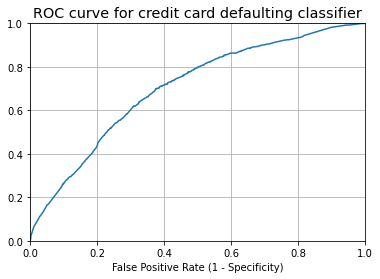

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [97]:
from sklearn import metrics
print(metrics.confusion_matrix(test_y, y_pred))

[[8338   15]
 [1612   35]]
